In [54]:
from vtraj.ode import * 
from dataclasses import astuple, asdict

import pandas as pd


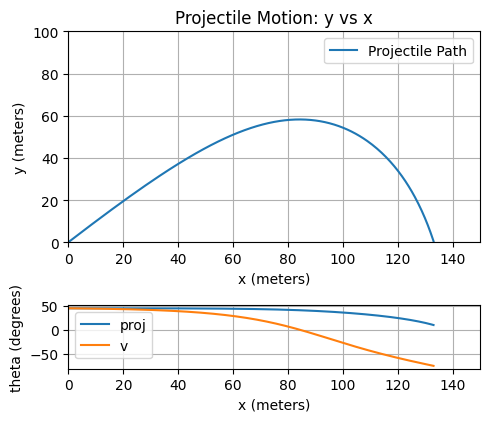

In [138]:
obs_params = Parameters(**{'Kp_theta': 0.1, 'C_d_1': 0.047, 'A_1': 0.045, 'C_d_2': 0.06, 'A_2': 0.08})
obs_ctx = Context( error=0, dt=1 / 30, params=obs_params)

v0 = 100
angle = 45

sol, df = throw(v0=v0, angle=angle, ctx=obs_ctx, dense_output=True)
plot_traj(df)

In [109]:
# "Observed" data
def mk_sol_df(sol, t = None):
    """Make a dataframe from the ODE solution"""
    if t is None:
        return pd.DataFrame(np.hstack([sol.t.reshape((-1,1)), sol.y.T]), columns="t x y theta vx vy".split())
    else:
        
        return pd.DataFrame(np.hstack([t.values.reshape((-1,1)), sol.sol(t).T]), columns="t x y theta vx vy".split())
        
obs = mk_sol_df(sol)
obs = obs[['t','x','y','theta']]

In [144]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Objective function to minimize

def err(df1, df2):

    df1 = df1[['t','x','y']]
    df2 = df2[['t','x','y']]

    return np.sqrt(np.sum(np.square(df1-df2).values))


def objective_function(params, ctx, obs ):

    ctx.params=Parameters(*params)

    sol, df = throw(v0=params[0], angle=params[1], ctx=ctx, dense_output=True)

    y = mk_sol_df(sol, obs['t'])

    return err(y, obs)

params = Parameters(**{'Kp_theta': 0.5, 'C_d_1': 0.02, 'A_1': 0.02, 'C_d_2': 0.02, 'A_2': 0.02})

initial_params = np.array(astuple(obs_params))*1.1 # astuple(params)
initial_params = [v0, angle]
# Perform the optimization

result = minimize(objective_function, initial_params, args=(obs_ctx, obs))

print("Orig Parameters:     ", np.array(astuple(obs_params)))
print("Initial Parameters:  ", initial_params)
print("Optimized parameters:", result.x)


Orig Parameters:      [0.1   0.047 0.045 0.06  0.08 ]
Initial Parameters:   [100, 45]
Optimized parameters: [85.08648335 78.87369782]


797.7418819587432

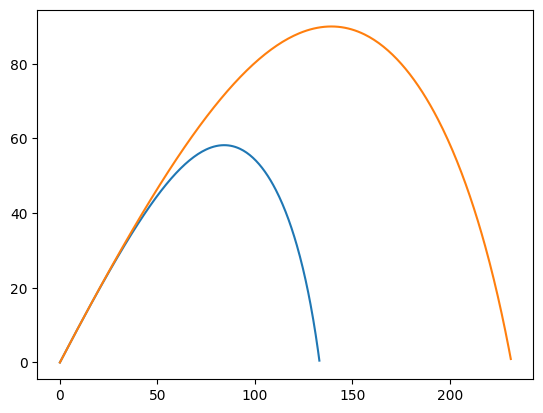

In [140]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)

ctx = Context( error=0, dt=1 / 30, params=obs_params)
sol1, df = throw(v0=v0, angle=angle, ctx=ctx, dense_output=True)

ax.plot(df.x, df.y)

ctx = Context( error=0, dt=1 / 30, params=Parameters(*result.x))
sol2, df = throw(v0=v0, angle=angle, ctx=ctx, dense_output=True)

ax.plot(df.x, df.y)

def err(df1, df2):

    df1 = df1[['t','x','y']]
    df2 = df2[['t','x','y']]

    return np.sqrt(np.sum(np.square(df1-df2).values))

d1 = mk_sol_df(sol1)
d2 = mk_sol_df(sol2,d1.t)

err(d1, d2)

0.0